In [1]:
import os
import pandas as pd

dir = "/Users/sryhandiniputeri/bluesky/log/LoSSev"
subdirs = next(os.walk(dir))[1]
os.chdir(dir)

In [2]:
fullpath = []
statistic = {}

for subdir in subdirs:
  lastdir = dir + "/" + subdir
  lastdir_list = next(os.walk(lastdir))[1]
  statistic[subdir] = {}

  
lastdir_list.sort()

for lastdir in lastdir_list:
  fullpath.append(dir+"/"+subdir+"/"+lastdir)

In [110]:
import scipy.stats as stats

def get_statistic(path):
  statistic_fcn = {}

  los_sev = get_los_sev(path)
  mean, (lower_bound, upper_bound), nb_data = get_mean_conf_interval(los_sev)

  statistic_fcn['data'] = los_sev
  statistic_fcn['mean'] = mean
  statistic_fcn['lb'] = lower_bound
  statistic_fcn['ub'] = upper_bound
  statistic_fcn['nb_data'] = nb_data

  return statistic_fcn


def get_los_sev(path):
  for dirname, _, filenames in os.walk(path):
      filename_index = 0
      los_sev = []

      for filename in filenames:
        if(filename[:3] == 'cpa'):
          filename_index += 1
          full_filename = os.path.join(dirname, filename)

          df = pd.read_csv(full_filename, index_col = 0)
          if('30' in full_filename[:-19]):
            dictionary = {(index, column): (30-value)/30 for index, row in df.iterrows() for column, value in row.items() if value < 100}
          else:
            dictionary = {(index, column): (50-value)/50 for index, row in df.iterrows() for column, value in row.items() if value < 100}
            
          values = list(dictionary.values())
          los_sev.extend(values)
      
  return los_sev

def get_mean_conf_interval(lista):
  confidence = 0.95
  if(len(lista) > 0):
    mean = sum(lista) / len(lista)
    std_error = stats.sem(lista)
    margin_of_error = std_error * stats.t.ppf((1 + confidence) / 2, len(lista) - 1)
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return (mean, (lower_bound, upper_bound), len(lista))
  else:
    return (-1, (-1, -1), -1)

In [111]:
for subdir in subdirs:
  for lastdir in lastdir_list:
    fullpath = dir+"/"+subdir+"/"+lastdir
    print(fullpath)
    statistic[subdir][lastdir] = get_statistic(fullpath)

/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_100_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_100_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_15_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_15_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_50_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_50_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_6_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_1.5_mvp_noise/DT_6_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_5_mvp_noise/DT_100_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_5_mvp_noise/DT_100_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_5_mvp_noise/DT_15_RPZ_30
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_5_mvp_noise/DT_15_RPZ_50
/Users/sryhandiniputeri/bluesky/log/LoSSev/hpos_5_mvp_noise/DT_50_RPZ_30
/Users/sryhandiniputeri/bluesky/l

In [12]:
import matplotlib.pyplot as plt

def plot_confidence_interval(x, stat_dict, color='#2187bb', horizontal_line_width=0.25):
    mean = stat_dict['mean']
    left = x - horizontal_line_width / 2
    top = stat_dict['ub']
    right = x + horizontal_line_width / 2
    bottom = stat_dict['lb']
    
#     print(stat_dict['nb_data'])
    
    if(mean < 0):
        mean = 0
        top = 0
        bottom = 0
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color = color)

In [10]:
#RPZ 30, HPOZ 15
import statistics
import numpy as np

def get_plot_double(statistic, hpos, ylim):
  xtick = 1

  for RPZ in ['30', '50']:

    for dt_lookahead in [6, 15, 50, 100]:

      for noise in [0, 1]:
        if(noise):
#             plot_confidence_interval(xtick + 0.1, statistic[f'hpos_{hpos}_mvp_noise'][f'DT_{dt_lookahead}_RPZ_{RPZ}'], color = 'b')
#             print(f'hpos_{hpos}_mvp_noise', f'DT_{dt_lookahead}_RPZ_{RPZ}')
            
        else:
            plot_confidence_interval(xtick - 0.1, statistic[f'hpos_{hpos}_mvp'][f'DT_{dt_lookahead}_RPZ_{RPZ}'], color = 'r')
#             print(f'hpos_{hpos}_mvp', f'DT_{dt_lookahead}_RPZ_{RPZ}')
            
      xtick += 1

  plt.xlabel("Lookahead Time [s]")
  plt.ylabel("LoS Severity [-]")
  
  plt.title(f'HPOS 95% Bound {hpos} m')
  plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['6', '15', '50', '100', '6', '15', '50', '100'])
  plt.ylim([ylim[0], ylim[1]])

  legend1 = plt.legend(['Ideal', 'ADSL'], bbox_to_anchor=(1.04, 1), loc="upper left")
  ax = plt.gca()
  leg = ax.get_legend()
  leg.legend_handles[0].set_color('red')
  leg.legend_handles[1].set_color('blue')

  colors = plt.cm.gray(np.linspace(0.8, 0.2, 4))

  area_1 = ax.axvspan(0.5, 4.5, alpha=0.5, color=colors[0])
  area_2 = ax.axvspan(4.5, 8.5, alpha=0.5, color=colors[2])

  # legend2 = plt.legend([l[0] for l in plot_lines], parameters, loc=4)
  legend2 = plt.legend((area_1, area_2), ('RPZ 30', 'RPZ 50'), numpoints=1, bbox_to_anchor=(1.04, 0.8), loc="upper left")
  plt.gca().add_artist(legend1)

  plt.show()

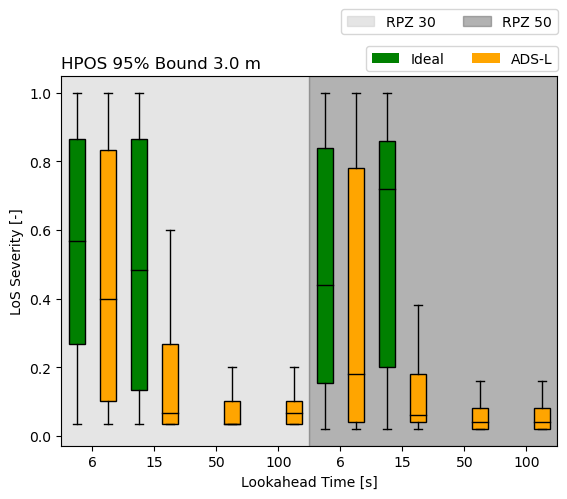

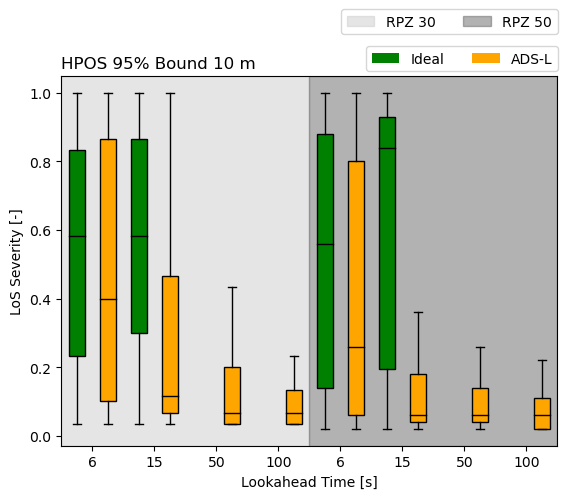

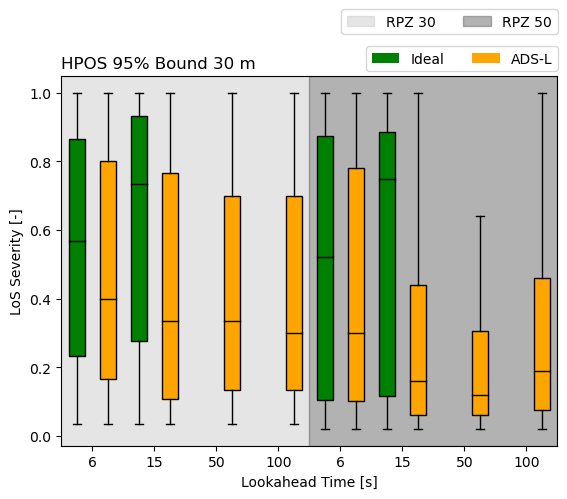

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
 
# Creating dataset
hpos = 1.5

def get_box_plot(hpos):
    data = []

    dt_lookahead_list = [6, 15, 50, 100]
    rpz_list = ['30', '50']
    
    for RPZ in rpz_list:
        for dt_lookahead in dt_lookahead_list:
            for noise in [0, 1]:
                if(noise):
                    data.append(statistic[f'hpos_{hpos}_mvp_noise'][f'DT_{dt_lookahead}_RPZ_{RPZ}']['data'])
                else:
                    data.append(statistic[f'hpos_{hpos}_mvp'][f'DT_{dt_lookahead}_RPZ_{RPZ}']['data'])

    colors = ['green', 'orange'] * len(dt_lookahead_list) * len(rpz_list)
        
    boxplot = plt.boxplot(data, showfliers=False, patch_artist=True)
    
    for box, color in zip(boxplot['boxes'], colors):
        box.set(facecolor=color)
        
    for median in boxplot['medians']:
        median.set(color='black')
        
    plt.xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5])
    ax = plt.gca()
    ax.set_xticklabels(['6', '15', '50', '100', '6', '15', '50', '100'])

#     legend1 = plt.legend(['Ideal', 'ADSL'], bbox_to_anchor=(1.04, 1), loc="upper left")
#     ax = plt.gca()
#     leg = ax.get_legend()
    
    legend_handles = [mpatches.Patch(facecolor='green'), mpatches.Patch(facecolor='orange')]
    legend_labels = ['Ideal', 'ADS-L']
    legend1 = plt.legend(legend_handles, legend_labels, bbox_to_anchor=(0.6, 1.1), loc="upper left", ncol= 2)
    
    colors = plt.cm.gray(np.linspace(0.8, 0.2, 4))
    area_1 = ax.axvspan(0.5, 8.5, alpha=0.5, color=colors[0])
    area_2 = ax.axvspan(8.5, 16.5, alpha=0.5, color=colors[2])
    
    legend2 = plt.legend((area_1, area_2), ('RPZ 30', 'RPZ 50'), ncol = 2, numpoints=1, bbox_to_anchor=(0.55, 1.2), loc="upper left")
    plt.gca().add_artist(legend1)
    
    plt.xlabel("Lookahead Time [s]")
    plt.ylabel("LoS Severity [-]")
    plt.title(f'HPOS 95% Bound {hpos*2} m', loc = 'left')
    
hpos_list = [1.5, 5, 15]

for i in range(len(hpos_list)):
    plt.figure(i)
    get_box_plot(hpos_list[i])

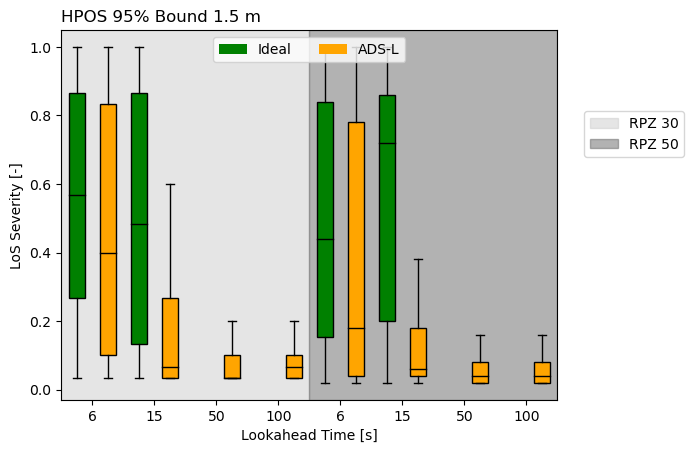

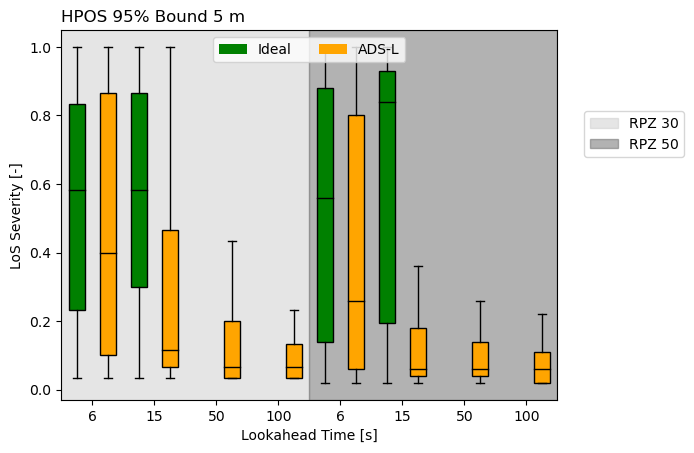

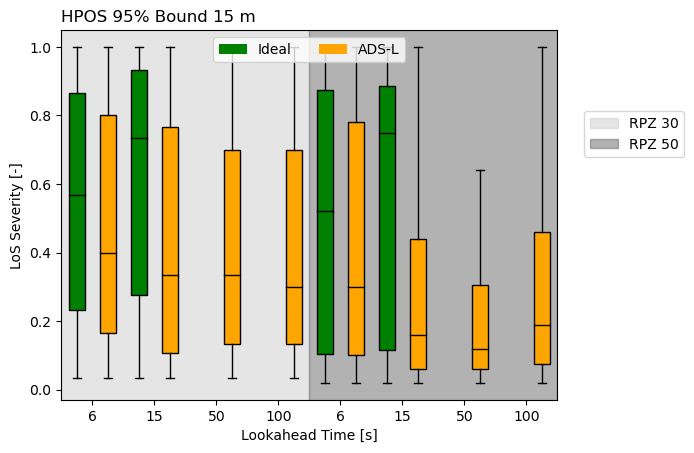